In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "0:1"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 87612 images
Dataset type val label type: species


Loaded 21905 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1 pfcye2eb


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-pfcye2eb:best, 314.55MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:10.0


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                          | 0/685 [00:00<?, ?it/s]

  0%|▏                                                                                                                 | 1/685 [00:02<22:48,  2.00s/it]

  1%|▋                                                                                                                 | 4/685 [00:02<04:40,  2.43it/s]

  1%|█▏                                                                                                                | 7/685 [00:02<02:23,  4.72it/s]

  1%|█▋                                                                                                               | 10/685 [00:02<01:32,  7.29it/s]

  2%|██▏                                                                                                              | 13/685 [00:02<01:06, 10.06it/s]

  2%|██▋                                                                                                              | 16/685 [00:02<00:52, 12.79it/s]

  3%|███▏                                                                                                             | 19/685 [00:02<00:43, 15.41it/s]

  3%|███▋                                                                                                             | 22/685 [00:02<00:37, 17.70it/s]

  4%|████                                                                                                             | 25/685 [00:02<00:33, 19.58it/s]

  4%|████▌                                                                                                            | 28/685 [00:03<00:31, 21.18it/s]

  5%|█████                                                                                                            | 31/685 [00:03<00:29, 22.45it/s]

  5%|█████▌                                                                                                           | 34/685 [00:03<00:27, 23.27it/s]

  5%|██████                                                                                                           | 37/685 [00:03<00:26, 24.00it/s]

  6%|██████▌                                                                                                          | 40/685 [00:03<00:26, 24.42it/s]

  6%|███████                                                                                                          | 43/685 [00:03<00:25, 24.94it/s]

  7%|███████▌                                                                                                         | 46/685 [00:03<00:25, 25.22it/s]

  7%|████████                                                                                                         | 49/685 [00:03<00:25, 25.27it/s]

  8%|████████▌                                                                                                        | 52/685 [00:03<00:24, 25.50it/s]

  8%|█████████                                                                                                        | 55/685 [00:04<00:24, 25.70it/s]

  8%|█████████▌                                                                                                       | 58/685 [00:04<00:24, 25.62it/s]

  9%|██████████                                                                                                       | 61/685 [00:04<00:24, 25.72it/s]

  9%|██████████▌                                                                                                      | 64/685 [00:04<00:23, 25.89it/s]

 10%|███████████                                                                                                      | 67/685 [00:04<00:24, 25.74it/s]

 10%|███████████▌                                                                                                     | 70/685 [00:04<00:23, 25.78it/s]

 11%|████████████                                                                                                     | 73/685 [00:04<00:23, 25.81it/s]

 11%|████████████▌                                                                                                    | 76/685 [00:04<00:23, 25.80it/s]

 12%|█████████████                                                                                                    | 79/685 [00:05<00:23, 25.82it/s]

 12%|█████████████▌                                                                                                   | 82/685 [00:05<00:23, 25.83it/s]

 12%|██████████████                                                                                                   | 85/685 [00:05<00:23, 25.75it/s]

 13%|██████████████▌                                                                                                  | 88/685 [00:05<00:23, 25.88it/s]

 13%|███████████████                                                                                                  | 91/685 [00:05<00:23, 25.73it/s]

 14%|███████████████▌                                                                                                 | 94/685 [00:05<00:23, 25.62it/s]

 14%|████████████████                                                                                                 | 97/685 [00:05<00:22, 25.68it/s]

 15%|████████████████▎                                                                                               | 100/685 [00:05<00:22, 25.62it/s]

 15%|████████████████▊                                                                                               | 103/685 [00:05<00:22, 25.55it/s]

 15%|█████████████████▎                                                                                              | 106/685 [00:06<00:22, 25.65it/s]

 16%|█████████████████▊                                                                                              | 109/685 [00:06<00:22, 25.89it/s]

 16%|██████████████████▎                                                                                             | 112/685 [00:06<00:22, 25.88it/s]

 17%|██████████████████▊                                                                                             | 115/685 [00:06<00:22, 25.88it/s]

 17%|███████████████████▎                                                                                            | 118/685 [00:06<00:22, 25.77it/s]

 18%|███████████████████▊                                                                                            | 121/685 [00:06<00:21, 25.90it/s]

 18%|████████████████████▎                                                                                           | 124/685 [00:06<00:21, 25.88it/s]

 19%|████████████████████▊                                                                                           | 127/685 [00:06<00:21, 25.73it/s]

 19%|█████████████████████▎                                                                                          | 130/685 [00:07<00:21, 25.76it/s]

 19%|█████████████████████▋                                                                                          | 133/685 [00:07<00:21, 25.81it/s]

 20%|██████████████████████▏                                                                                         | 136/685 [00:07<00:21, 25.69it/s]

 20%|██████████████████████▋                                                                                         | 139/685 [00:07<00:21, 25.75it/s]

 21%|███████████████████████▏                                                                                        | 142/685 [00:07<00:21, 25.73it/s]

 21%|███████████████████████▋                                                                                        | 145/685 [00:07<00:21, 25.62it/s]

 22%|████████████████████████▏                                                                                       | 148/685 [00:07<00:20, 25.68it/s]

 22%|████████████████████████▋                                                                                       | 151/685 [00:07<00:20, 25.60it/s]

 22%|█████████████████████████▏                                                                                      | 154/685 [00:07<00:20, 25.75it/s]

 23%|█████████████████████████▋                                                                                      | 157/685 [00:08<00:20, 25.77it/s]

 23%|██████████████████████████▏                                                                                     | 160/685 [00:08<00:20, 25.67it/s]

 24%|██████████████████████████▋                                                                                     | 163/685 [00:08<00:20, 25.79it/s]

 24%|███████████████████████████▏                                                                                    | 166/685 [00:08<00:20, 25.89it/s]

 25%|███████████████████████████▋                                                                                    | 169/685 [00:08<00:20, 25.75it/s]

 25%|████████████████████████████                                                                                    | 172/685 [00:08<00:19, 25.65it/s]

 26%|████████████████████████████▌                                                                                   | 175/685 [00:08<00:19, 25.88it/s]

 26%|█████████████████████████████                                                                                   | 178/685 [00:08<00:19, 25.73it/s]

 26%|█████████████████████████████▌                                                                                  | 181/685 [00:08<00:19, 25.77it/s]

 27%|██████████████████████████████                                                                                  | 184/685 [00:09<00:19, 25.81it/s]

 27%|██████████████████████████████▌                                                                                 | 187/685 [00:09<00:19, 25.83it/s]

 28%|███████████████████████████████                                                                                 | 190/685 [00:09<00:19, 25.83it/s]

 28%|███████████████████████████████▌                                                                                | 193/685 [00:09<00:19, 25.85it/s]

 29%|████████████████████████████████                                                                                | 196/685 [00:09<00:18, 25.76it/s]

 29%|████████████████████████████████▌                                                                               | 199/685 [00:09<00:18, 25.87it/s]

 29%|█████████████████████████████████                                                                               | 202/685 [00:09<00:18, 25.87it/s]

 30%|█████████████████████████████████▌                                                                              | 205/685 [00:09<00:18, 25.73it/s]

 30%|██████████████████████████████████                                                                              | 208/685 [00:10<00:18, 25.90it/s]

 31%|██████████████████████████████████▍                                                                             | 211/685 [00:10<00:18, 25.91it/s]

 31%|██████████████████████████████████▉                                                                             | 214/685 [00:10<00:18, 25.74it/s]

 32%|███████████████████████████████████▍                                                                            | 217/685 [00:10<00:18, 25.76it/s]

 32%|███████████████████████████████████▉                                                                            | 220/685 [00:10<00:17, 25.90it/s]

 33%|████████████████████████████████████▍                                                                           | 223/685 [00:10<00:17, 25.75it/s]

 33%|████████████████████████████████████▉                                                                           | 226/685 [00:10<00:17, 25.79it/s]

 33%|█████████████████████████████████████▍                                                                          | 229/685 [00:10<00:17, 25.70it/s]

 34%|█████████████████████████████████████▉                                                                          | 232/685 [00:10<00:17, 25.70it/s]

 34%|██████████████████████████████████████▍                                                                         | 235/685 [00:11<00:17, 25.74it/s]

 35%|██████████████████████████████████████▉                                                                         | 238/685 [00:11<00:17, 25.64it/s]

 35%|███████████████████████████████████████▍                                                                        | 241/685 [00:11<00:17, 25.67it/s]

 36%|███████████████████████████████████████▉                                                                        | 244/685 [00:11<00:17, 25.73it/s]

 36%|████████████████████████████████████████▍                                                                       | 247/685 [00:11<00:17, 25.62it/s]

 36%|████████████████████████████████████████▉                                                                       | 250/685 [00:11<00:17, 25.54it/s]

 37%|█████████████████████████████████████████▎                                                                      | 253/685 [00:11<00:16, 25.78it/s]

 37%|█████████████████████████████████████████▊                                                                      | 256/685 [00:11<00:16, 25.81it/s]

 38%|██████████████████████████████████████████▎                                                                     | 259/685 [00:12<00:16, 25.68it/s]

 38%|██████████████████████████████████████████▊                                                                     | 262/685 [00:12<00:16, 25.79it/s]

 39%|███████████████████████████████████████████▎                                                                    | 265/685 [00:12<00:16, 25.86it/s]

 39%|███████████████████████████████████████████▊                                                                    | 268/685 [00:12<00:16, 25.71it/s]

 40%|████████████████████████████████████████████▎                                                                   | 271/685 [00:12<00:16, 25.76it/s]

 40%|████████████████████████████████████████████▊                                                                   | 274/685 [00:12<00:16, 25.65it/s]

 40%|█████████████████████████████████████████████▎                                                                  | 277/685 [00:12<00:15, 25.59it/s]

 41%|█████████████████████████████████████████████▊                                                                  | 280/685 [00:12<00:15, 25.66it/s]

 41%|██████████████████████████████████████████████▎                                                                 | 283/685 [00:12<00:15, 25.60it/s]

 42%|██████████████████████████████████████████████▊                                                                 | 286/685 [00:13<00:15, 25.68it/s]

 42%|███████████████████████████████████████████████▎                                                                | 289/685 [00:13<00:15, 25.72it/s]

 43%|███████████████████████████████████████████████▋                                                                | 292/685 [00:13<00:15, 25.63it/s]

 43%|████████████████████████████████████████████████▏                                                               | 295/685 [00:13<00:15, 25.71it/s]

 44%|████████████████████████████████████████████████▋                                                               | 298/685 [00:13<00:14, 25.90it/s]

 44%|█████████████████████████████████████████████████▏                                                              | 301/685 [00:13<00:14, 25.75it/s]

 44%|█████████████████████████████████████████████████▋                                                              | 304/685 [00:13<00:14, 25.79it/s]

 45%|██████████████████████████████████████████████████▏                                                             | 307/685 [00:13<00:14, 25.82it/s]

 45%|██████████████████████████████████████████████████▋                                                             | 310/685 [00:14<00:14, 25.80it/s]

 46%|███████████████████████████████████████████████████▏                                                            | 313/685 [00:14<00:14, 25.80it/s]

 46%|███████████████████████████████████████████████████▋                                                            | 316/685 [00:14<00:14, 25.83it/s]

 47%|████████████████████████████████████████████████████▏                                                           | 319/685 [00:14<00:14, 25.75it/s]

 47%|████████████████████████████████████████████████████▋                                                           | 322/685 [00:14<00:14, 25.93it/s]

 47%|█████████████████████████████████████████████████████▏                                                          | 325/685 [00:14<00:13, 25.83it/s]

 48%|█████████████████████████████████████████████████████▋                                                          | 328/685 [00:14<00:13, 25.84it/s]

 48%|██████████████████████████████████████████████████████                                                          | 331/685 [00:14<00:13, 25.86it/s]

 49%|██████████████████████████████████████████████████████▌                                                         | 334/685 [00:14<00:13, 25.72it/s]

 49%|███████████████████████████████████████████████████████                                                         | 337/685 [00:15<00:13, 25.75it/s]

 50%|███████████████████████████████████████████████████████▌                                                        | 340/685 [00:15<00:13, 25.80it/s]

 50%|████████████████████████████████████████████████████████                                                        | 343/685 [00:15<00:13, 25.63it/s]

 51%|████████████████████████████████████████████████████████▌                                                       | 346/685 [00:15<00:13, 25.71it/s]

 51%|█████████████████████████████████████████████████████████                                                       | 349/685 [00:15<00:13, 25.63it/s]

 51%|█████████████████████████████████████████████████████████▌                                                      | 352/685 [00:15<00:12, 25.67it/s]

 52%|██████████████████████████████████████████████████████████                                                      | 355/685 [00:15<00:12, 25.74it/s]

 52%|██████████████████████████████████████████████████████████▌                                                     | 358/685 [00:15<00:12, 25.58it/s]

 53%|███████████████████████████████████████████████████████████                                                     | 361/685 [00:15<00:12, 25.59it/s]

 53%|███████████████████████████████████████████████████████████▌                                                    | 364/685 [00:16<00:12, 25.78it/s]

 54%|████████████████████████████████████████████████████████████                                                    | 367/685 [00:16<00:12, 25.66it/s]

 54%|████████████████████████████████████████████████████████████▍                                                   | 370/685 [00:16<00:12, 25.72it/s]

 54%|████████████████████████████████████████████████████████████▉                                                   | 373/685 [00:16<00:12, 25.98it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 376/685 [00:16<00:11, 25.89it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                  | 379/685 [00:16<00:11, 25.75it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                 | 382/685 [00:16<00:11, 25.93it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                 | 385/685 [00:16<00:11, 25.90it/s]

 57%|███████████████████████████████████████████████████████████████▍                                                | 388/685 [00:17<00:11, 25.91it/s]

 57%|███████████████████████████████████████████████████████████████▉                                                | 391/685 [00:17<00:11, 25.90it/s]

 58%|████████████████████████████████████████████████████████████████▍                                               | 394/685 [00:17<00:11, 25.75it/s]

 58%|████████████████████████████████████████████████████████████████▉                                               | 397/685 [00:17<00:11, 25.81it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                              | 400/685 [00:17<00:11, 25.83it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                              | 403/685 [00:17<00:10, 25.65it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                             | 406/685 [00:17<00:10, 25.84it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                             | 409/685 [00:17<00:10, 26.06it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                            | 412/685 [00:17<00:10, 25.85it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                            | 415/685 [00:18<00:10, 25.87it/s]

 61%|████████████████████████████████████████████████████████████████████▎                                           | 418/685 [00:18<00:10, 25.77it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                           | 421/685 [00:18<00:10, 25.76it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                          | 424/685 [00:18<00:10, 25.79it/s]

 62%|█████████████████████████████████████████████████████████████████████▊                                          | 427/685 [00:18<00:10, 25.67it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                         | 430/685 [00:18<00:09, 25.82it/s]

 63%|██████████████████████████████████████████████████████████████████████▊                                         | 433/685 [00:18<00:09, 25.83it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                        | 436/685 [00:18<00:09, 25.69it/s]

 64%|███████████████████████████████████████████████████████████████████████▊                                        | 439/685 [00:19<00:09, 25.73it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                       | 442/685 [00:19<00:09, 26.05it/s]

 65%|████████████████████████████████████████████████████████████████████████▊                                       | 445/685 [00:19<00:09, 25.85it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                      | 448/685 [00:19<00:09, 25.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                      | 451/685 [00:19<00:08, 26.08it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                     | 454/685 [00:19<00:08, 25.96it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 457/685 [00:19<00:08, 25.80it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                    | 460/685 [00:19<00:08, 25.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                    | 463/685 [00:19<00:08, 25.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████▏                                   | 466/685 [00:20<00:08, 25.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████▋                                   | 469/685 [00:20<00:08, 25.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▏                                  | 472/685 [00:20<00:08, 25.73it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                  | 475/685 [00:20<00:08, 25.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                 | 478/685 [00:20<00:07, 25.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                 | 481/685 [00:20<00:07, 25.73it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                                | 484/685 [00:20<00:07, 25.77it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▋                                | 487/685 [00:20<00:07, 25.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                                | 490/685 [00:20<00:07, 25.61it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▌                               | 493/685 [00:21<00:07, 25.70it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                               | 496/685 [00:21<00:07, 25.96it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                              | 499/685 [00:21<00:07, 25.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████                              | 502/685 [00:21<00:07, 25.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                             | 505/685 [00:21<00:06, 25.73it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████                             | 508/685 [00:21<00:06, 25.91it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                            | 511/685 [00:21<00:06, 25.85it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████                            | 514/685 [00:21<00:06, 25.78it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                           | 517/685 [00:22<00:06, 25.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████                           | 520/685 [00:22<00:06, 25.96it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                          | 523/685 [00:22<00:06, 25.79it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                          | 526/685 [00:22<00:06, 25.95it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▍                         | 529/685 [00:22<00:06, 25.96it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                         | 532/685 [00:22<00:05, 25.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▍                        | 535/685 [00:22<00:05, 25.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                        | 538/685 [00:22<00:05, 25.88it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▍                       | 541/685 [00:22<00:05, 25.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                       | 544/685 [00:23<00:05, 25.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▍                      | 547/685 [00:23<00:05, 25.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                      | 550/685 [00:23<00:05, 25.74it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                     | 553/685 [00:23<00:05, 25.94it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                     | 556/685 [00:23<00:05, 25.78it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                    | 559/685 [00:23<00:04, 25.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▉                    | 562/685 [00:23<00:04, 25.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                   | 565/685 [00:23<00:04, 25.93it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▊                   | 568/685 [00:24<00:04, 25.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                  | 571/685 [00:24<00:04, 25.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                  | 574/685 [00:24<00:04, 25.69it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▎                 | 577/685 [00:24<00:04, 25.89it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                 | 580/685 [00:24<00:04, 25.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▎                | 583/685 [00:24<00:03, 25.68it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊                | 586/685 [00:24<00:03, 26.00it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▎               | 589/685 [00:24<00:03, 25.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊               | 592/685 [00:24<00:03, 25.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▎              | 595/685 [00:25<00:03, 25.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊              | 598/685 [00:25<00:03, 25.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▎             | 601/685 [00:25<00:03, 25.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▊             | 604/685 [00:25<00:03, 25.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏            | 607/685 [00:25<00:03, 25.74it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▋            | 610/685 [00:25<00:02, 25.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 613/685 [00:25<00:02, 25.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 616/685 [00:25<00:02, 25.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 619/685 [00:25<00:02, 25.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 622/685 [00:26<00:02, 25.89it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 625/685 [00:26<00:02, 25.73it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 628/685 [00:26<00:02, 25.78it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 631/685 [00:26<00:02, 25.95it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 634/685 [00:26<00:01, 25.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 637/685 [00:26<00:01, 25.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 640/685 [00:26<00:01, 25.72it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 643/685 [00:26<00:01, 25.73it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 646/685 [00:27<00:01, 25.74it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████      | 649/685 [00:27<00:01, 25.66it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 652/685 [00:27<00:01, 25.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████     | 655/685 [00:27<00:01, 25.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 658/685 [00:27<00:01, 25.50it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 661/685 [00:27<00:00, 25.49it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 664/685 [00:27<00:00, 25.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 667/685 [00:27<00:00, 25.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 670/685 [00:27<00:00, 25.64it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 673/685 [00:28<00:00, 25.72it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 676/685 [00:28<00:00, 25.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 679/685 [00:28<00:00, 25.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 682/685 [00:28<00:00, 25.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [00:28<00:00, 21.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [00:28<00:00, 23.91it/s]

train - OK


  0%|                                                                                                                          | 0/172 [00:00<?, ?it/s]

  1%|▋                                                                                                                 | 1/172 [00:00<00:29,  5.78it/s]

  2%|██▋                                                                                                               | 4/172 [00:00<00:10, 15.30it/s]

  4%|████▋                                                                                                             | 7/172 [00:00<00:08, 19.41it/s]

  6%|██████▌                                                                                                          | 10/172 [00:00<00:07, 21.69it/s]

  8%|████████▌                                                                                                        | 13/172 [00:00<00:06, 23.13it/s]

  9%|██████████▌                                                                                                      | 16/172 [00:00<00:06, 23.89it/s]

 11%|████████████▍                                                                                                    | 19/172 [00:00<00:06, 24.54it/s]

 13%|██████████████▍                                                                                                  | 22/172 [00:00<00:05, 25.04it/s]

 15%|████████████████▍                                                                                                | 25/172 [00:01<00:05, 25.17it/s]

 16%|██████████████████▍                                                                                              | 28/172 [00:01<00:05, 25.37it/s]

 18%|████████████████████▎                                                                                            | 31/172 [00:01<00:05, 25.38it/s]

 20%|██████████████████████▎                                                                                          | 34/172 [00:01<00:05, 25.53it/s]

 22%|████████████████████████▎                                                                                        | 37/172 [00:01<00:05, 25.64it/s]

 23%|██████████████████████████▎                                                                                      | 40/172 [00:01<00:05, 25.57it/s]

 25%|████████████████████████████▎                                                                                    | 43/172 [00:01<00:05, 25.71it/s]

 27%|██████████████████████████████▏                                                                                  | 46/172 [00:01<00:04, 25.86it/s]

 28%|████████████████████████████████▏                                                                                | 49/172 [00:02<00:04, 25.72it/s]

 30%|██████████████████████████████████▏                                                                              | 52/172 [00:02<00:04, 25.77it/s]

 32%|████████████████████████████████████▏                                                                            | 55/172 [00:02<00:04, 25.90it/s]

 34%|██████████████████████████████████████                                                                           | 58/172 [00:02<00:04, 25.74it/s]

 35%|████████████████████████████████████████                                                                         | 61/172 [00:02<00:04, 25.77it/s]

 37%|██████████████████████████████████████████                                                                       | 64/172 [00:02<00:04, 25.82it/s]

 39%|████████████████████████████████████████████                                                                     | 67/172 [00:02<00:04, 25.83it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 70/172 [00:02<00:03, 25.84it/s]

 42%|███████████████████████████████████████████████▉                                                                 | 73/172 [00:02<00:03, 25.87it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 76/172 [00:03<00:03, 25.76it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 79/172 [00:03<00:03, 25.87it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 82/172 [00:03<00:03, 25.87it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 85/172 [00:03<00:03, 25.60it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 88/172 [00:03<00:03, 25.79it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 91/172 [00:03<00:03, 25.82it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 94/172 [00:03<00:03, 25.71it/s]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 97/172 [00:03<00:02, 25.77it/s]

 58%|█████████████████████████████████████████████████████████████████                                               | 100/172 [00:04<00:02, 25.96it/s]

 60%|███████████████████████████████████████████████████████████████████                                             | 103/172 [00:04<00:02, 25.79it/s]

 62%|█████████████████████████████████████████████████████████████████████                                           | 106/172 [00:04<00:02, 25.82it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                         | 109/172 [00:04<00:02, 25.91it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                       | 112/172 [00:04<00:02, 25.80it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                     | 115/172 [00:04<00:02, 25.82it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                   | 118/172 [00:04<00:02, 25.71it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                 | 121/172 [00:04<00:01, 25.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▋                               | 124/172 [00:04<00:01, 25.69it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                             | 127/172 [00:05<00:01, 25.62it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                           | 130/172 [00:05<00:01, 25.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                         | 133/172 [00:05<00:01, 26.00it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▌                       | 136/172 [00:05<00:01, 25.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▌                     | 139/172 [00:05<00:01, 25.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▍                   | 142/172 [00:05<00:01, 25.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                 | 145/172 [00:05<00:01, 26.16it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▎               | 148/172 [00:05<00:00, 26.08it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▎             | 151/172 [00:05<00:00, 26.01it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 154/172 [00:06<00:00, 26.03it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 157/172 [00:06<00:00, 26.07it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 160/172 [00:06<00:00, 26.01it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 163/172 [00:06<00:00, 25.84it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 166/172 [00:06<00:00, 25.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 169/172 [00:06<00:00, 25.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:06<00:00, 23.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:06<00:00, 24.94it/s]

val - OK


  0%|                                                                                                                          | 0/328 [00:00<?, ?it/s]

  0%|▎                                                                                                                 | 1/328 [00:00<01:03,  5.12it/s]

  1%|█▍                                                                                                                | 4/328 [00:00<00:22, 14.63it/s]

  2%|██▍                                                                                                               | 7/328 [00:00<00:16, 18.93it/s]

  3%|███▍                                                                                                             | 10/328 [00:00<00:14, 21.43it/s]

  4%|████▍                                                                                                            | 13/328 [00:00<00:13, 22.51it/s]

  5%|█████▌                                                                                                           | 16/328 [00:00<00:13, 23.81it/s]

  6%|██████▌                                                                                                          | 19/328 [00:00<00:12, 24.47it/s]

  7%|███████▌                                                                                                         | 22/328 [00:01<00:12, 24.91it/s]

  8%|████████▌                                                                                                        | 25/328 [00:01<00:11, 25.26it/s]

  9%|█████████▋                                                                                                       | 28/328 [00:01<00:11, 25.53it/s]

  9%|██████████▋                                                                                                      | 31/328 [00:01<00:11, 25.63it/s]

 10%|███████████▋                                                                                                     | 34/328 [00:01<00:11, 25.55it/s]

 11%|████████████▋                                                                                                    | 37/328 [00:01<00:11, 26.11it/s]

 12%|█████████████▊                                                                                                   | 40/328 [00:01<00:11, 25.91it/s]

 13%|██████████████▊                                                                                                  | 43/328 [00:01<00:11, 25.75it/s]

 14%|███████████████▊                                                                                                 | 46/328 [00:01<00:10, 25.80it/s]

 15%|████████████████▉                                                                                                | 49/328 [00:02<00:10, 25.94it/s]

 16%|█████████████████▉                                                                                               | 52/328 [00:02<00:10, 25.78it/s]

 17%|██████████████████▉                                                                                              | 55/328 [00:02<00:10, 25.80it/s]

 18%|███████████████████▉                                                                                             | 58/328 [00:02<00:10, 25.71it/s]

 19%|█████████████████████                                                                                            | 61/328 [00:02<00:10, 25.75it/s]

 20%|██████████████████████                                                                                           | 64/328 [00:02<00:10, 25.78it/s]

 20%|███████████████████████                                                                                          | 67/328 [00:02<00:10, 25.68it/s]

 21%|████████████████████████                                                                                         | 70/328 [00:02<00:09, 25.93it/s]

 22%|█████████████████████████▏                                                                                       | 73/328 [00:02<00:09, 26.17it/s]

 23%|██████████████████████████▏                                                                                      | 76/328 [00:03<00:09, 25.93it/s]

 24%|███████████████████████████▏                                                                                     | 79/328 [00:03<00:09, 25.93it/s]

 25%|████████████████████████████▎                                                                                    | 82/328 [00:03<00:09, 26.37it/s]

 26%|█████████████████████████████▎                                                                                   | 85/328 [00:03<00:09, 26.07it/s]

 27%|██████████████████████████████▎                                                                                  | 88/328 [00:03<00:09, 26.01it/s]

 28%|███████████████████████████████▎                                                                                 | 91/328 [00:03<00:09, 25.99it/s]

 29%|████████████████████████████████▍                                                                                | 94/328 [00:03<00:08, 26.07it/s]

 30%|█████████████████████████████████▍                                                                               | 97/328 [00:03<00:08, 26.02it/s]

 30%|██████████████████████████████████▏                                                                             | 100/328 [00:04<00:08, 25.99it/s]

 31%|███████████████████████████████████▏                                                                            | 103/328 [00:04<00:08, 25.80it/s]

 32%|████████████████████████████████████▏                                                                           | 106/328 [00:04<00:08, 26.36it/s]

 33%|█████████████████████████████████████▏                                                                          | 109/328 [00:04<00:08, 26.07it/s]

 34%|██████████████████████████████████████▏                                                                         | 112/328 [00:04<00:08, 25.88it/s]

 35%|███████████████████████████████████████▎                                                                        | 115/328 [00:04<00:08, 26.08it/s]

 36%|████████████████████████████████████████▎                                                                       | 118/328 [00:04<00:08, 25.96it/s]

 37%|█████████████████████████████████████████▎                                                                      | 121/328 [00:04<00:08, 25.80it/s]

 38%|██████████████████████████████████████████▎                                                                     | 124/328 [00:04<00:07, 25.83it/s]

 39%|███████████████████████████████████████████▎                                                                    | 127/328 [00:05<00:07, 26.00it/s]

 40%|████████████████████████████████████████████▍                                                                   | 130/328 [00:05<00:07, 25.97it/s]

 41%|█████████████████████████████████████████████▍                                                                  | 133/328 [00:05<00:07, 25.94it/s]

 41%|██████████████████████████████████████████████▍                                                                 | 136/328 [00:05<00:07, 25.79it/s]

 42%|███████████████████████████████████████████████▍                                                                | 139/328 [00:05<00:07, 25.97it/s]

 43%|████████████████████████████████████████████████▍                                                               | 142/328 [00:05<00:07, 25.94it/s]

 44%|█████████████████████████████████████████████████▌                                                              | 145/328 [00:05<00:07, 25.79it/s]

 45%|██████████████████████████████████████████████████▌                                                             | 148/328 [00:05<00:06, 25.86it/s]

 46%|███████████████████████████████████████████████████▌                                                            | 151/328 [00:05<00:06, 25.83it/s]

 47%|████████████████████████████████████████████████████▌                                                           | 154/328 [00:06<00:06, 25.71it/s]

 48%|█████████████████████████████████████████████████████▌                                                          | 157/328 [00:06<00:06, 25.77it/s]

 49%|██████████████████████████████████████████████████████▋                                                         | 160/328 [00:06<00:06, 26.00it/s]

 50%|███████████████████████████████████████████████████████▋                                                        | 163/328 [00:06<00:06, 26.06it/s]

 51%|████████████████████████████████████████████████████████▋                                                       | 166/328 [00:06<00:06, 26.00it/s]

 52%|█████████████████████████████████████████████████████████▋                                                      | 169/328 [00:06<00:06, 25.96it/s]

 52%|██████████████████████████████████████████████████████████▋                                                     | 172/328 [00:06<00:05, 26.07it/s]

 53%|███████████████████████████████████████████████████████████▊                                                    | 175/328 [00:06<00:05, 26.02it/s]

 54%|████████████████████████████████████████████████████████████▊                                                   | 178/328 [00:07<00:05, 25.84it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 181/328 [00:07<00:05, 25.72it/s]

 56%|██████████████████████████████████████████████████████████████▊                                                 | 184/328 [00:07<00:05, 26.05it/s]

 57%|███████████████████████████████████████████████████████████████▊                                                | 187/328 [00:07<00:05, 25.86it/s]

 58%|████████████████████████████████████████████████████████████████▉                                               | 190/328 [00:07<00:05, 25.72it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                              | 193/328 [00:07<00:05, 25.95it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                             | 196/328 [00:07<00:05, 25.86it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                            | 199/328 [00:07<00:04, 25.88it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                           | 202/328 [00:07<00:04, 25.89it/s]

 62%|██████████████████████████████████████████████████████████████████████                                          | 205/328 [00:08<00:04, 25.89it/s]

 63%|███████████████████████████████████████████████████████████████████████                                         | 208/328 [00:08<00:04, 26.00it/s]

 64%|████████████████████████████████████████████████████████████████████████                                        | 211/328 [00:08<00:04, 25.97it/s]

 65%|█████████████████████████████████████████████████████████████████████████                                       | 214/328 [00:08<00:04, 25.80it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                      | 217/328 [00:08<00:04, 26.10it/s]

 67%|███████████████████████████████████████████████████████████████████████████                                     | 220/328 [00:08<00:04, 26.02it/s]

 68%|████████████████████████████████████████████████████████████████████████████▏                                   | 223/328 [00:08<00:04, 25.86it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▏                                  | 226/328 [00:08<00:03, 25.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                 | 229/328 [00:08<00:03, 26.15it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                                | 232/328 [00:09<00:03, 25.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                               | 235/328 [00:09<00:03, 25.81it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                              | 238/328 [00:09<00:03, 26.04it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                             | 241/328 [00:09<00:03, 25.92it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                            | 244/328 [00:09<00:03, 25.90it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                           | 247/328 [00:09<00:03, 25.77it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▎                          | 250/328 [00:09<00:03, 25.95it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▍                         | 253/328 [00:09<00:02, 26.01it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▍                        | 256/328 [00:10<00:02, 25.90it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▍                       | 259/328 [00:10<00:02, 25.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▍                      | 262/328 [00:10<00:02, 25.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                     | 265/328 [00:10<00:02, 25.65it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                    | 268/328 [00:10<00:02, 25.71it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                   | 271/328 [00:10<00:02, 25.75it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                  | 274/328 [00:10<00:02, 26.17it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                 | 277/328 [00:10<00:01, 26.09it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                | 280/328 [00:10<00:01, 25.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋               | 283/328 [00:11<00:01, 25.93it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▋              | 286/328 [00:11<00:01, 25.99it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▋             | 289/328 [00:11<00:01, 25.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▋            | 292/328 [00:11<00:01, 25.68it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 295/328 [00:11<00:01, 26.01it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 298/328 [00:11<00:01, 25.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 301/328 [00:11<00:01, 25.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 304/328 [00:11<00:00, 25.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 307/328 [00:12<00:00, 26.01it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 310/328 [00:12<00:00, 25.97it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 313/328 [00:12<00:00, 25.94it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 316/328 [00:12<00:00, 25.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 319/328 [00:12<00:00, 25.79it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 322/328 [00:12<00:00, 25.81it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 325/328 [00:12<00:00, 25.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:12<00:00, 24.68it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:12<00:00, 25.43it/s]

test InD - OK


  0%|                                                                                                                          | 0/437 [00:00<?, ?it/s]

  0%|▎                                                                                                                 | 1/437 [00:00<01:35,  4.58it/s]

  1%|█                                                                                                                 | 4/437 [00:00<00:31, 13.66it/s]

  2%|█▊                                                                                                                | 7/437 [00:00<00:23, 18.18it/s]

  2%|██▌                                                                                                              | 10/437 [00:00<00:20, 20.80it/s]

  3%|███▎                                                                                                             | 13/437 [00:00<00:18, 22.36it/s]

  4%|████▏                                                                                                            | 16/437 [00:00<00:18, 23.35it/s]

  4%|████▉                                                                                                            | 19/437 [00:00<00:17, 24.14it/s]

  5%|█████▋                                                                                                           | 22/437 [00:01<00:16, 24.74it/s]

  6%|██████▍                                                                                                          | 25/437 [00:01<00:16, 24.95it/s]

  6%|███████▏                                                                                                         | 28/437 [00:01<00:16, 25.23it/s]

  7%|████████                                                                                                         | 31/437 [00:01<00:15, 25.49it/s]

  8%|████████▊                                                                                                        | 34/437 [00:01<00:15, 25.85it/s]

  8%|█████████▌                                                                                                       | 37/437 [00:01<00:15, 25.85it/s]

  9%|██████████▎                                                                                                      | 40/437 [00:01<00:15, 25.72it/s]

 10%|███████████                                                                                                      | 43/437 [00:01<00:15, 26.06it/s]

 11%|███████████▉                                                                                                     | 46/437 [00:01<00:15, 26.00it/s]

 11%|████████████▋                                                                                                    | 49/437 [00:02<00:15, 25.81it/s]

 12%|█████████████▍                                                                                                   | 52/437 [00:02<00:14, 25.84it/s]

 13%|██████████████▏                                                                                                  | 55/437 [00:02<00:14, 26.11it/s]

 13%|██████████████▉                                                                                                  | 58/437 [00:02<00:14, 25.91it/s]

 14%|███████████████▊                                                                                                 | 61/437 [00:02<00:14, 25.89it/s]

 15%|████████████████▌                                                                                                | 64/437 [00:02<00:14, 25.89it/s]

 15%|█████████████████▎                                                                                               | 67/437 [00:02<00:14, 26.13it/s]

 16%|██████████████████                                                                                               | 70/437 [00:02<00:14, 26.05it/s]

 17%|██████████████████▉                                                                                              | 73/437 [00:03<00:14, 26.00it/s]

 17%|███████████████████▋                                                                                             | 76/437 [00:03<00:13, 26.03it/s]

 18%|████████████████████▍                                                                                            | 79/437 [00:03<00:13, 26.06it/s]

 19%|█████████████████████▏                                                                                           | 82/437 [00:03<00:13, 25.86it/s]

 19%|█████████████████████▉                                                                                           | 85/437 [00:03<00:13, 25.71it/s]

 20%|██████████████████████▊                                                                                          | 88/437 [00:03<00:13, 26.03it/s]

 21%|███████████████████████▌                                                                                         | 91/437 [00:03<00:13, 25.87it/s]

 22%|████████████████████████▎                                                                                        | 94/437 [00:03<00:13, 25.72it/s]

 22%|█████████████████████████                                                                                        | 97/437 [00:03<00:13, 25.78it/s]

 23%|█████████████████████████▋                                                                                      | 100/437 [00:04<00:12, 25.97it/s]

 24%|██████████████████████████▍                                                                                     | 103/437 [00:04<00:12, 25.93it/s]

 24%|███████████████████████████▏                                                                                    | 106/437 [00:04<00:12, 25.91it/s]

 25%|███████████████████████████▉                                                                                    | 109/437 [00:04<00:12, 25.97it/s]

 26%|████████████████████████████▋                                                                                   | 112/437 [00:04<00:12, 25.99it/s]

 26%|█████████████████████████████▍                                                                                  | 115/437 [00:04<00:12, 25.97it/s]

 27%|██████████████████████████████▏                                                                                 | 118/437 [00:04<00:12, 25.81it/s]

 28%|███████████████████████████████                                                                                 | 121/437 [00:04<00:12, 25.86it/s]

 28%|███████████████████████████████▊                                                                                | 124/437 [00:04<00:12, 25.94it/s]

 29%|████████████████████████████████▌                                                                               | 127/437 [00:05<00:12, 25.78it/s]

 30%|█████████████████████████████████▎                                                                              | 130/437 [00:05<00:11, 25.80it/s]

 30%|██████████████████████████████████                                                                              | 133/437 [00:05<00:11, 26.09it/s]

 31%|██████████████████████████████████▊                                                                             | 136/437 [00:05<00:11, 25.87it/s]

 32%|███████████████████████████████████▌                                                                            | 139/437 [00:05<00:11, 25.87it/s]

 32%|████████████████████████████████████▍                                                                           | 142/437 [00:05<00:11, 25.87it/s]

 33%|█████████████████████████████████████▏                                                                          | 145/437 [00:05<00:11, 26.01it/s]

 34%|█████████████████████████████████████▉                                                                          | 148/437 [00:05<00:11, 25.97it/s]

 35%|██████████████████████████████████████▋                                                                         | 151/437 [00:06<00:11, 25.80it/s]

 35%|███████████████████████████████████████▍                                                                        | 154/437 [00:06<00:10, 25.88it/s]

 36%|████████████████████████████████████████▏                                                                       | 157/437 [00:06<00:10, 26.14it/s]

 37%|█████████████████████████████████████████                                                                       | 160/437 [00:06<00:10, 25.90it/s]

 37%|█████████████████████████████████████████▊                                                                      | 163/437 [00:06<00:10, 25.75it/s]

 38%|██████████████████████████████████████████▌                                                                     | 166/437 [00:06<00:10, 25.98it/s]

 39%|███████████████████████████████████████████▎                                                                    | 169/437 [00:06<00:10, 25.89it/s]

 39%|████████████████████████████████████████████                                                                    | 172/437 [00:06<00:10, 25.88it/s]

 40%|████████████████████████████████████████████▊                                                                   | 175/437 [00:06<00:10, 25.90it/s]

 41%|█████████████████████████████████████████████▌                                                                  | 178/437 [00:07<00:09, 26.09it/s]

 41%|██████████████████████████████████████████████▍                                                                 | 181/437 [00:07<00:09, 26.02it/s]

 42%|███████████████████████████████████████████████▏                                                                | 184/437 [00:07<00:09, 25.96it/s]

 43%|███████████████████████████████████████████████▉                                                                | 187/437 [00:07<00:09, 25.80it/s]

 43%|████████████████████████████████████████████████▋                                                               | 190/437 [00:07<00:09, 26.09it/s]

 44%|█████████████████████████████████████████████████▍                                                              | 193/437 [00:07<00:09, 26.04it/s]

 45%|██████████████████████████████████████████████████▏                                                             | 196/437 [00:07<00:09, 25.85it/s]

 46%|███████████████████████████████████████████████████                                                             | 199/437 [00:07<00:09, 26.08it/s]

 46%|███████████████████████████████████████████████████▊                                                            | 202/437 [00:07<00:08, 26.12it/s]

 47%|████████████████████████████████████████████████████▌                                                           | 205/437 [00:08<00:08, 25.92it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 208/437 [00:08<00:08, 25.91it/s]

 48%|██████████████████████████████████████████████████████                                                          | 211/437 [00:08<00:08, 25.88it/s]

 49%|██████████████████████████████████████████████████████▊                                                         | 214/437 [00:08<00:08, 25.78it/s]

 50%|███████████████████████████████████████████████████████▌                                                        | 217/437 [00:08<00:08, 25.82it/s]

 50%|████████████████████████████████████████████████████████▍                                                       | 220/437 [00:08<00:08, 25.70it/s]

 51%|█████████████████████████████████████████████████████████▏                                                      | 223/437 [00:08<00:08, 25.70it/s]

 52%|█████████████████████████████████████████████████████████▉                                                      | 226/437 [00:08<00:08, 25.76it/s]

 52%|██████████████████████████████████████████████████████████▋                                                     | 229/437 [00:09<00:08, 25.66it/s]

 53%|███████████████████████████████████████████████████████████▍                                                    | 232/437 [00:09<00:08, 25.57it/s]

 54%|████████████████████████████████████████████████████████████▍                                                   | 236/437 [00:09<00:07, 27.78it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 241/437 [00:09<00:06, 31.94it/s]

 56%|███████████████████████████████████████████████████████████████                                                 | 246/437 [00:09<00:05, 36.24it/s]

 57%|████████████████████████████████████████████████████████████████▎                                               | 251/437 [00:09<00:04, 39.64it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                              | 256/437 [00:09<00:04, 42.38it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                             | 261/437 [00:09<00:03, 44.34it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                           | 266/437 [00:09<00:03, 45.75it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                          | 271/437 [00:10<00:03, 46.74it/s]

 63%|██████████████████████████████████████████████████████████████████████▋                                         | 276/437 [00:10<00:03, 47.39it/s]

 64%|████████████████████████████████████████████████████████████████████████                                        | 281/437 [00:10<00:03, 47.85it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                      | 286/437 [00:10<00:03, 48.32it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                     | 291/437 [00:10<00:03, 43.70it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                    | 296/437 [00:10<00:03, 36.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                   | 300/437 [00:10<00:04, 32.84it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                  | 304/437 [00:10<00:04, 30.93it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                 | 308/437 [00:11<00:04, 29.39it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                | 312/437 [00:11<00:04, 28.38it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▋                               | 315/437 [00:11<00:04, 27.69it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                              | 318/437 [00:11<00:04, 27.09it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                             | 321/437 [00:11<00:04, 26.71it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████                             | 324/437 [00:11<00:04, 26.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                            | 327/437 [00:11<00:04, 26.43it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                           | 330/437 [00:11<00:04, 26.14it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▎                          | 333/437 [00:12<00:03, 26.06it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                          | 336/437 [00:12<00:03, 26.27it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                         | 339/437 [00:12<00:03, 26.01it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                        | 342/437 [00:12<00:03, 25.98it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▍                       | 345/437 [00:12<00:03, 25.95it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                      | 348/437 [00:12<00:03, 26.06it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                      | 351/437 [00:12<00:03, 26.00it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▋                     | 354/437 [00:12<00:03, 25.96it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                    | 357/437 [00:12<00:03, 25.97it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                   | 360/437 [00:13<00:02, 26.05it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████                   | 363/437 [00:13<00:02, 25.99it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                  | 366/437 [00:13<00:02, 25.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                 | 369/437 [00:13<00:02, 26.04it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▎                | 372/437 [00:13<00:02, 25.93it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 375/437 [00:13<00:02, 25.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 378/437 [00:13<00:02, 25.79it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▋              | 381/437 [00:13<00:02, 26.08it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▍             | 384/437 [00:14<00:02, 25.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏            | 387/437 [00:14<00:01, 25.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▉            | 390/437 [00:14<00:01, 25.73it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 393/437 [00:14<00:01, 25.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 396/437 [00:14<00:01, 25.90it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 399/437 [00:14<00:01, 25.75it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████         | 402/437 [00:14<00:01, 25.84it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 405/437 [00:14<00:01, 26.04it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 408/437 [00:14<00:01, 25.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 411/437 [00:15<00:01, 25.90it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████      | 414/437 [00:15<00:00, 26.19it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 417/437 [00:15<00:00, 26.05it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 420/437 [00:15<00:00, 26.01it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 423/437 [00:15<00:00, 25.96it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 426/437 [00:15<00:00, 25.92it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 429/437 [00:15<00:00, 25.92it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 432/437 [00:15<00:00, 25.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 435/437 [00:16<00:00, 25.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:16<00:00, 27.05it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, ftr=trn_ftr, emb=trn_emb, lgt=trn_lgt, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, ftr=val_ftr, emb=val_emb, lgt=val_lgt, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, ftr=ind_ftr, emb=ind_emb, lgt=ind_lgt, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, ftr=ood_ftr, emb=ood_emb, lgt=ood_lgt, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)

(87612, 3, 64, 64) (87612, 2048) (87612, 512) (87612, 2) (87612,)
(21905, 3, 64, 64) (21905, 2048) (21905, 512) (21905, 2) (21905,)
(41868, 3, 64, 64) (41868, 2048) (41868, 512) (41868, 2) (41868,)
(55824, 3, 64, 64) (55824, 2048) (55824, 512) (55824, 2) (55824,)


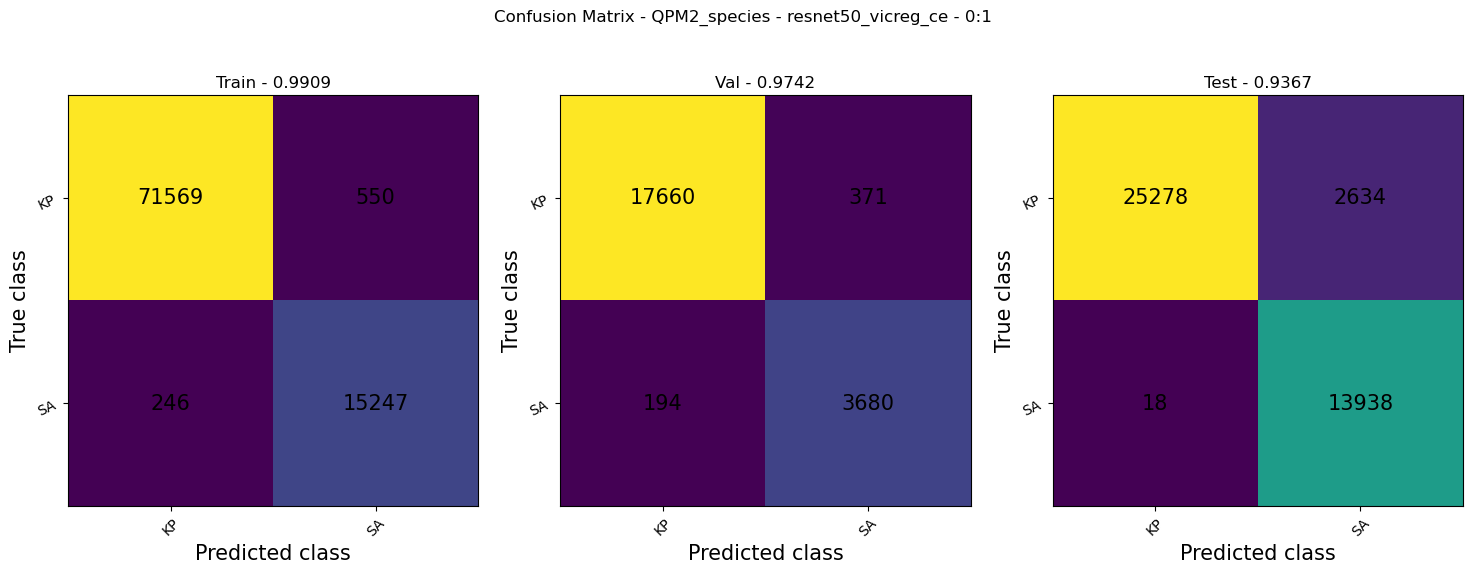

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(41868, 2) (55824, 2)
(41868, 2) (55824, 2)


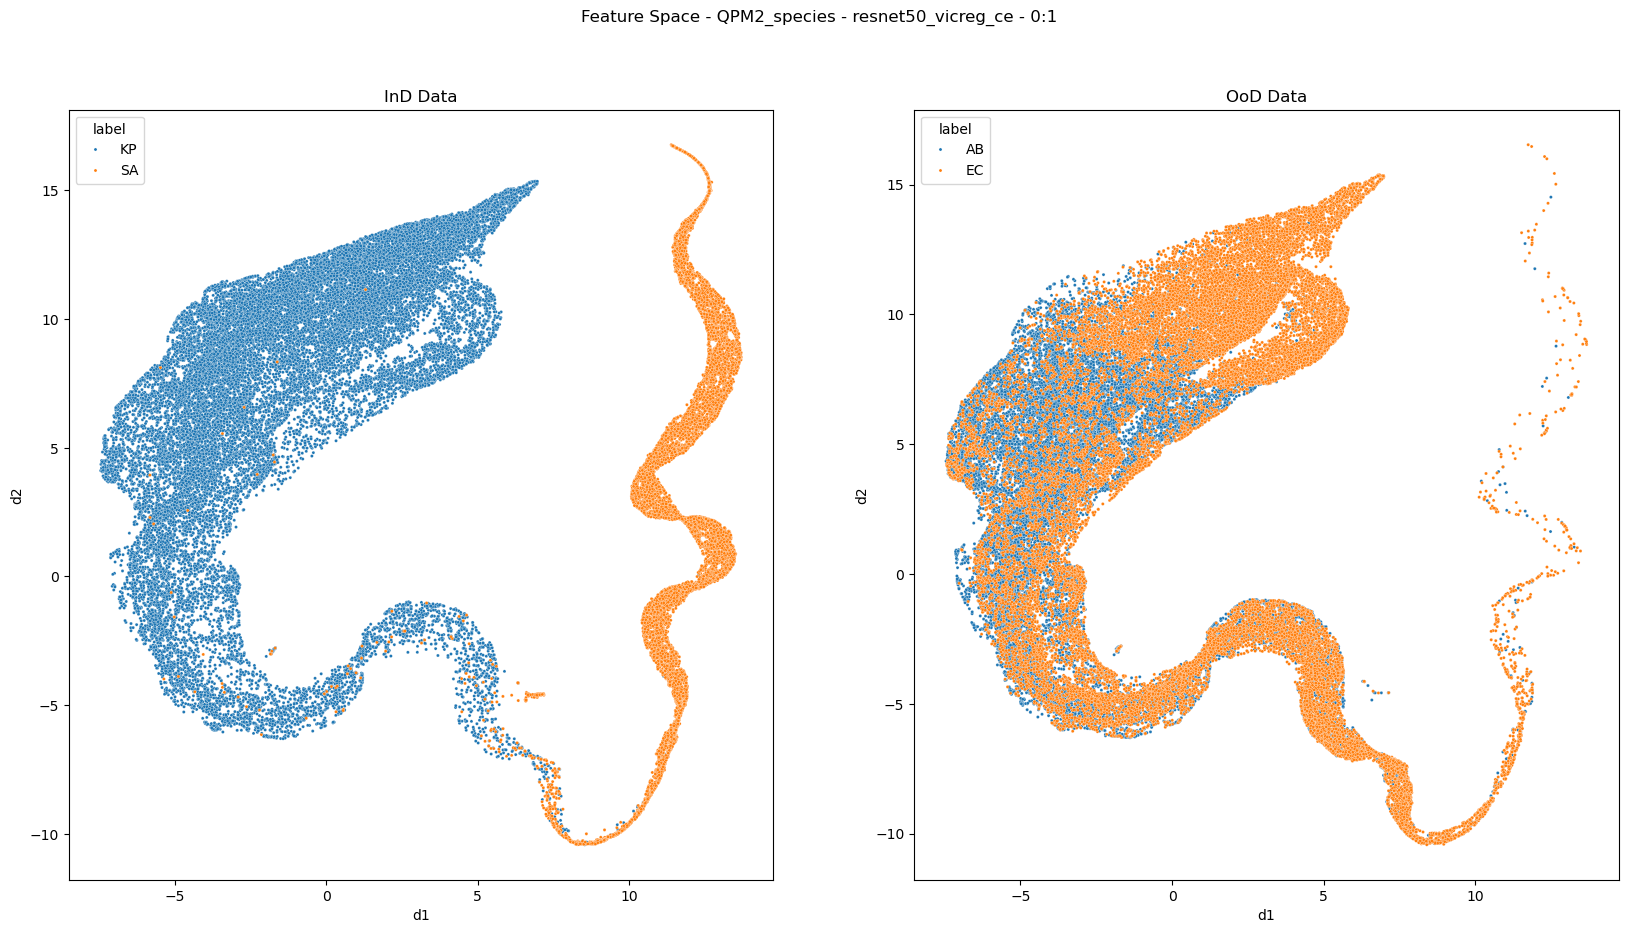

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

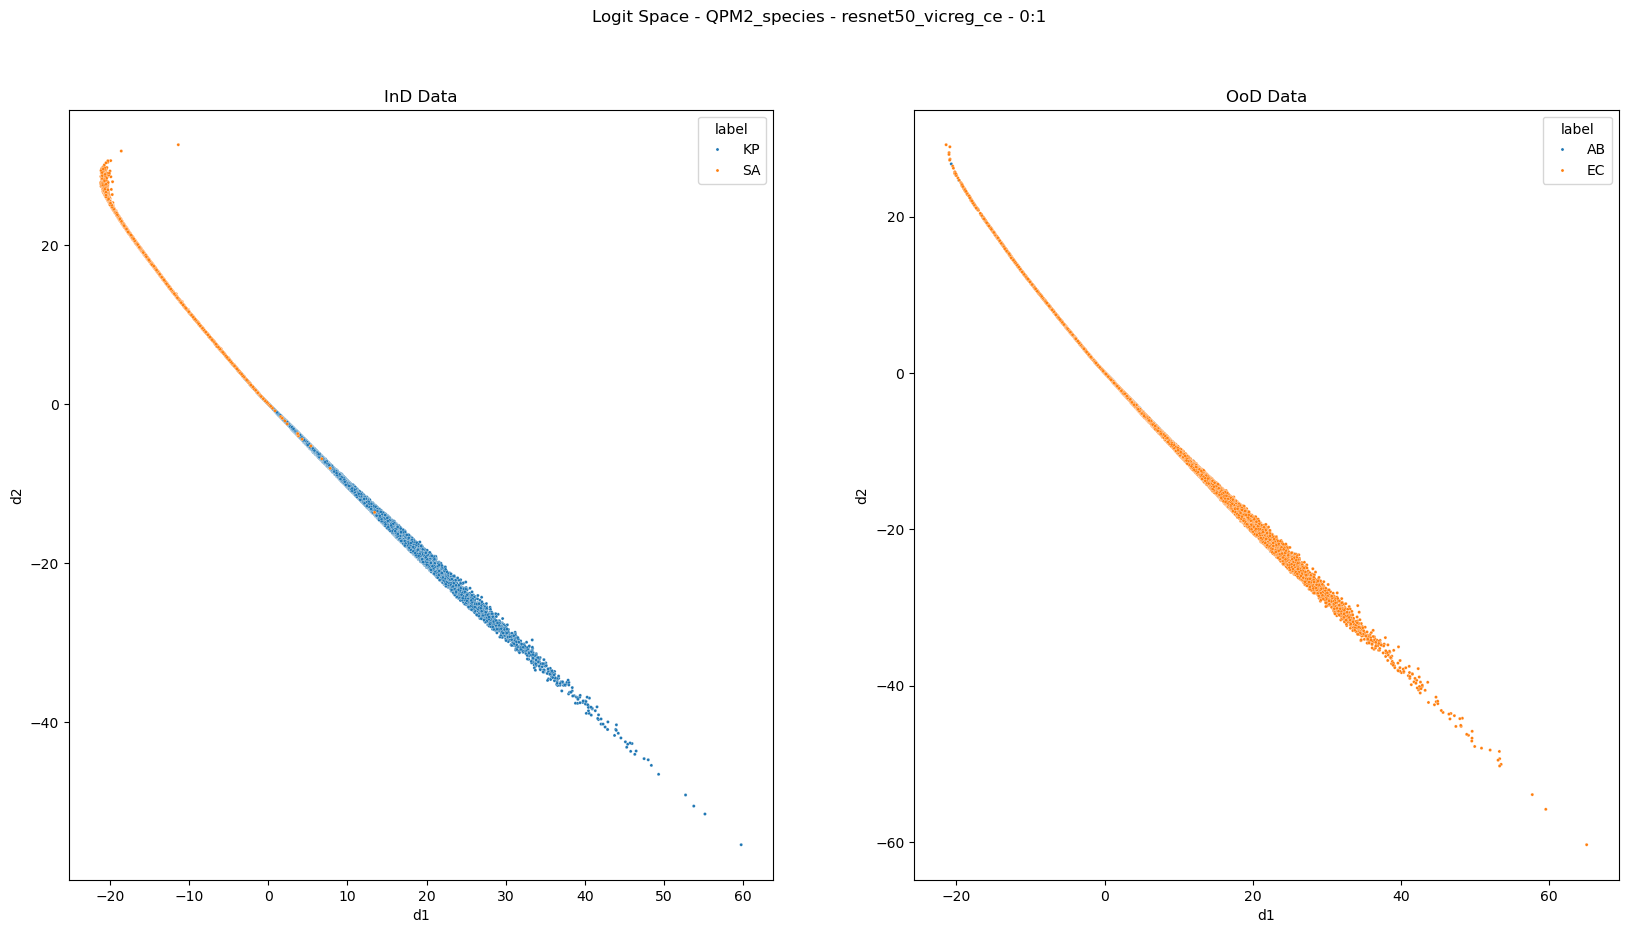

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

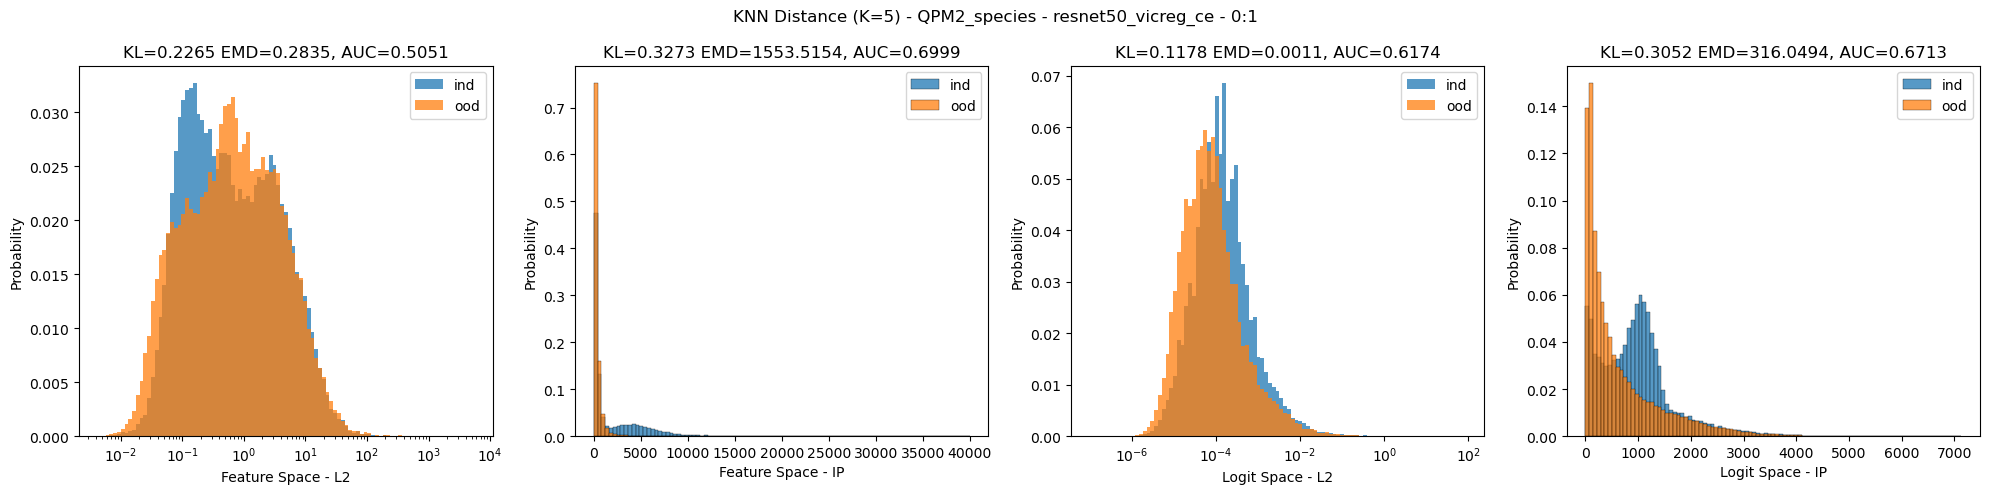

In [15]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

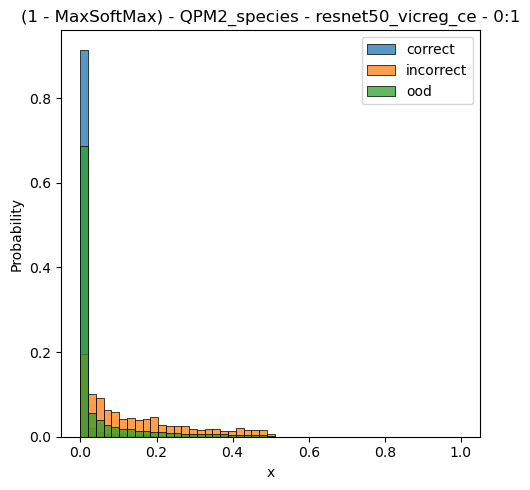

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [17]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)